In [248]:
import pandas as pd
import numpy as np
import tensorflow as tf
from data_loader import load_veterans_ds, prepare_veterans_ds
from sklearn.preprocessing import StandardScaler
from utility import InputFunction, CindexMetric, CoxPHLoss, _make_riskset, _TFColor, sample_hmc
import matplotlib.pyplot as plt
import seaborn as sns

TFColor = _TFColor()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [249]:
# Compute risk set for 5 samples
n_samples = 5
train_event_set = tf.expand_dims(e_train[:n_samples].astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train[:n_samples]))
pred_ = tf.convert_to_tensor(np.linspace(0.1, 0.9, n_samples).reshape(n_samples,1).astype(np.float32)) # random prediction

# Run loss function
loss_fn = CoxPHLoss()
loss_fn(y_true=[train_event_set, train_risks_set], y_pred=pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=1.047399>

In [250]:
dtype = tf.float32

X_train = np.array(X_train)

X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test = prepare_veterans_ds(y_train, y_valid, y_test)

X_train = np.array(X_train)

y_obs = tf.convert_to_tensor(t_train[e_train], dtype=dtype)
y_cens = tf.convert_to_tensor(t_train[~e_train], dtype=dtype)

x_obs = tf.convert_to_tensor(X_train[e_train][:,:2], dtype=dtype)
x_cens = tf.convert_to_tensor(X_train[~e_train][:,:2], dtype=dtype)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [251]:
def obs_model_fn(x_obs):
    return tfd.JointDistributionNamedAutoBatched(dict(
        alpha=tfd.Normal(loc=[tf.cast(0.0, dtype)], scale=[tf.cast(10.0, dtype)]),
        beta=tfd.Normal(loc=[[tf.cast(0.0, dtype)], [tf.cast(0.0, dtype)]], 
                        scale=[[tf.cast(10.0, dtype)], [tf.cast(10.0, dtype)]]
        ),
        y=lambda beta, alpha: tfd.Exponential(
            rate=1/tf.math.exp(tf.linalg.matmul(x_obs, beta) + alpha)
        )
    ))

def exponential_lccdf(x_cens, y_cens, beta, alpha):
    return tf.reduce_sum(-y_cens / tf.exp(tf.linalg.matmul(x_cens, beta) + alpha), axis=[0,1])

def target_log_prob_fn(x_obs, x_cens, y_obs, y_cens, beta, alpha):
    lp = obs_model_fn(x_obs).log_prob(beta=beta, alpha=alpha, y=y_obs)
    potential = exponential_lccdf(x_cens, y_cens, beta, alpha)
    return lp + potential

In [252]:
n_chains = 4
initial_coeffs = obs_model_fn(x_obs).sample(n_chains)

In [253]:
n_chains = 4
number_of_steps = 10000
number_burnin_steps = 1000

#initial_coeffs = obs_model_fn(x_obs).sample(n_chains)
unnormalized_post_log_prob = lambda *args: target_log_prob_fn(x_obs, x_cens, y_obs, y_cens, *args)
#initial_alpha = tf.convert_to_tensor([tf.reduce_mean(initial_coeffs['alpha'])], dtype=dtype)
#initial_beta = tf.convert_to_tensor(tf.reduce_mean(initial_coeffs['beta'], axis=0), dtype=dtype)
#initial_states = [initial_beta, initial_alpha]

In [254]:
# Size of each chain.
num_results = 10000
# Burn-in steps.
num_burnin_steps = 1000
# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_post_log_prob,
  step_size=1.0,
  num_leapfrog_steps=3
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[1.0], [1.0]], dtype=dtype),
          tf.convert_to_tensor([1.0], dtype=dtype)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [255]:
# Set number of chains.
num_chains = 4
# Run sampling.
chains = [run_chain() for i in range(num_chains)]

In [256]:
chains_t = list(map(list, zip(*chains)))
chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

In [257]:
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['beta_0', 'beta_1', 'alpha']
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % number_of_steps,
        chain_id=lambda x: (x['sample_id'] / number_of_steps).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,beta_0,beta_1,alpha,sample_id,chain_sample_id,chain_id
0,0.064079,0.984855,0.996394,0,0,c_1
1,0.064079,0.984855,0.996394,1,1,c_1
2,0.064079,0.984855,0.996394,2,2,c_1
3,0.064079,0.984855,0.996394,3,3,c_1
4,0.064150,0.983397,0.995135,4,4,c_1


Text(0.5, 1.03, 'Posterior Samples per Chain')

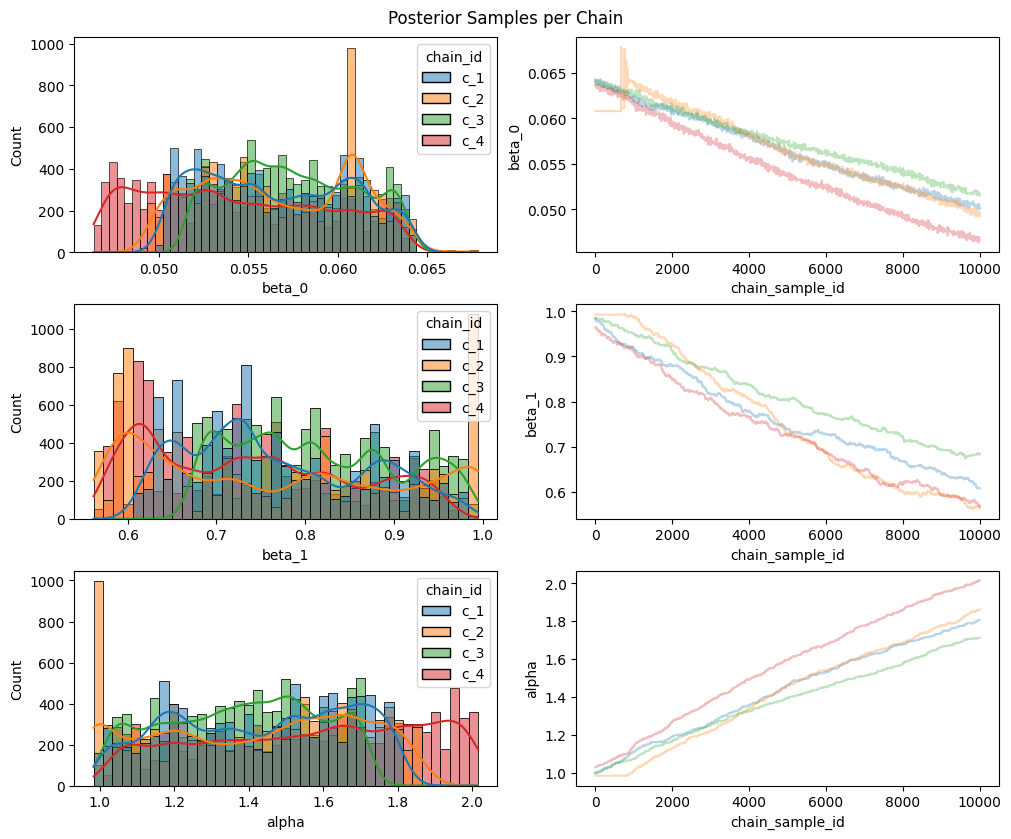

In [259]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03)

Text(0.5, 1.03, 'Posterior Samples')

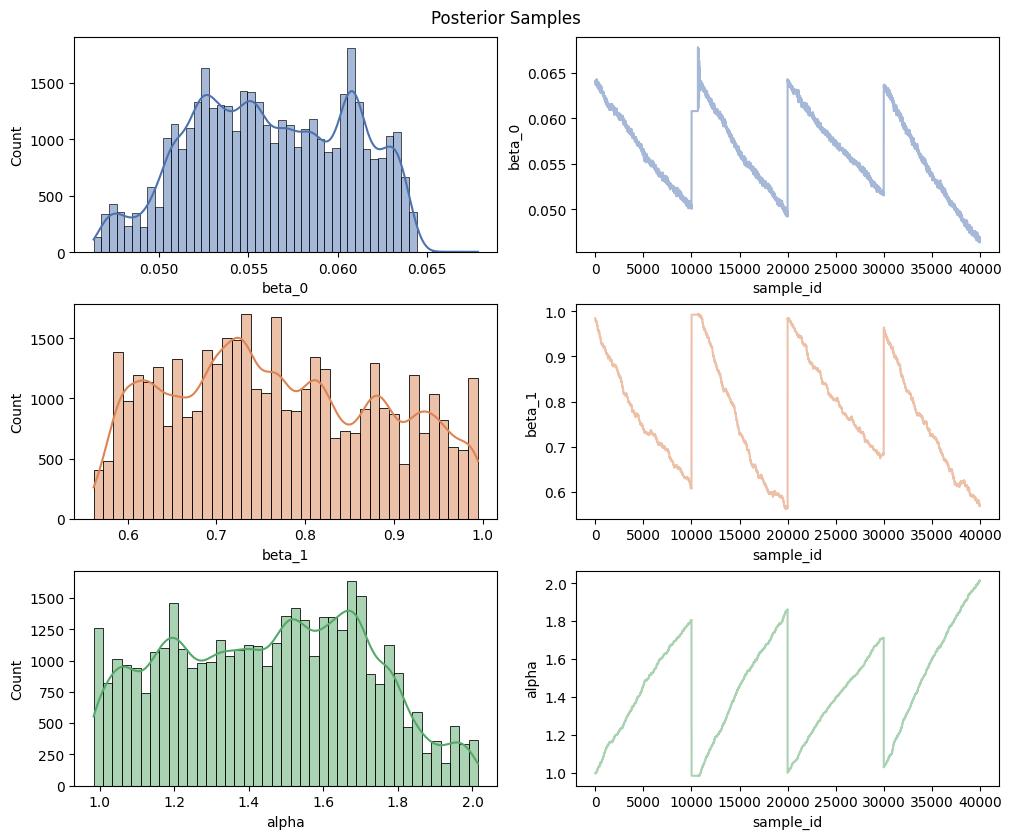

In [260]:
sns_c = sns.color_palette(palette='deep')

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.5, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03)

In [261]:
x = np.concatenate([x_obs, x_cens])

In [262]:
chains_samples[0][:,0]

<tf.Tensor: shape=(40000,), dtype=float32, numpy=
array([0.06407875, 0.06407875, 0.06407875, ..., 0.04666255, 0.04666255,
       0.04666255], dtype=float32)>

In [263]:
alphas = chains_samples[1]
beta_0 = chains_samples[0][:,0]
beta_1 = chains_samples[0][:,1]

In [264]:
lambda_ = np.exp(alphas)
lambda_

array([2.7084975, 2.7084975, 2.7084975, ..., 7.5001206, 7.5001206,
       7.5001206], dtype=float32)

Text(0.5, 0, '$\\lambda$')

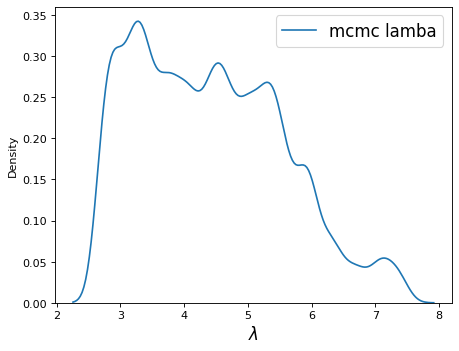

In [271]:
plt.figure(dpi=80)
sns.kdeplot(lambda_, label='mcmc lamba')
#sns.kdeplot(y_obs, label='obs lamba')
plt.legend(fontsize=15)
plt.xlabel("$\lambda$",size=15)

In [193]:
# Here we compute mu = alpha + beta x.
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x.shape[0]))) \
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x))

In [196]:
mu_posterior_samples

<tf.Tensor: shape=(50000, 109), dtype=float32, numpy=
array([[5.8783383, 5.7866282, 3.233558 , ..., 4.0647902, 4.955396 ,
        5.1335173],
       [5.8783383, 5.7866282, 3.233558 , ..., 4.0647902, 4.955396 ,
        5.1335173],
       [5.8783383, 5.7866282, 3.233558 , ..., 4.0647902, 4.955396 ,
        5.1335173],
       ...,
       [5.654685 , 5.785312 , 3.7544918, ..., 4.4156895, 5.124115 ,
        5.2658   ],
       [5.654685 , 5.785312 , 3.7544918, ..., 4.4156895, 5.124115 ,
        5.2658   ],
       [5.654685 , 5.785312 , 3.7544918, ..., 4.4156895, 5.124115 ,
        5.2658   ]], dtype=float32)>

In [120]:
alphas = alphas.numpy().flatten()
beta_0 = betas[:,0,:].numpy().flatten()
beta_1 = betas[:,1,:].numpy().flatten()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

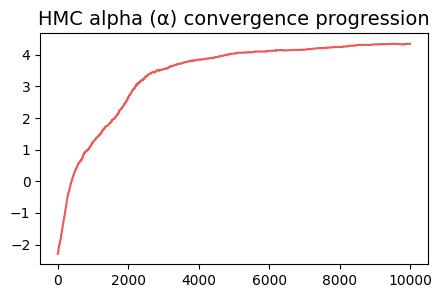

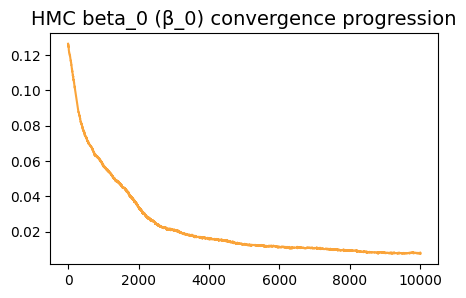

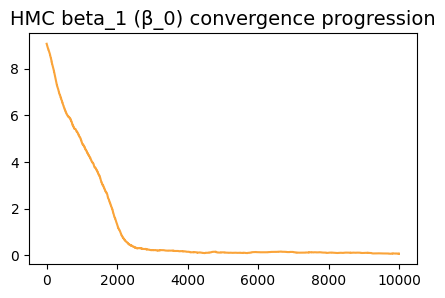

In [109]:
# plotting the Posterior Samples
plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), alphas, color=TFColor[0])
plt.title('HMC alpha (α) convergence progression', fontsize=14)

plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), beta_0, color=TFColor[1])
plt.title('HMC beta_0 (β_0) convergence progression', fontsize=14)

plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), beta_1, color=TFColor[1])
plt.title('HMC beta_1 (β_0) convergence progression', fontsize=14)
plt.show()

Text(0.5, 1.0, 'KDE plot for beta_1 (β_1) samples')

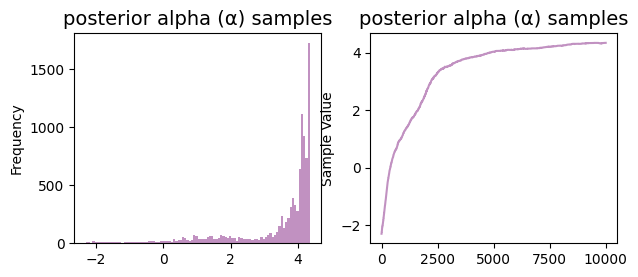

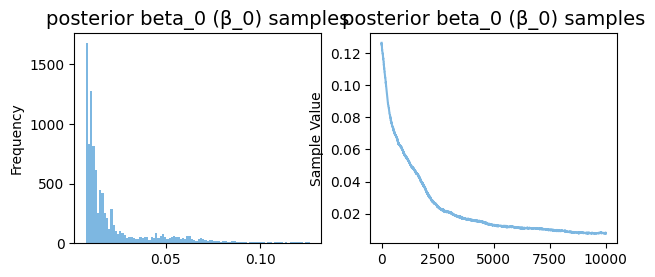

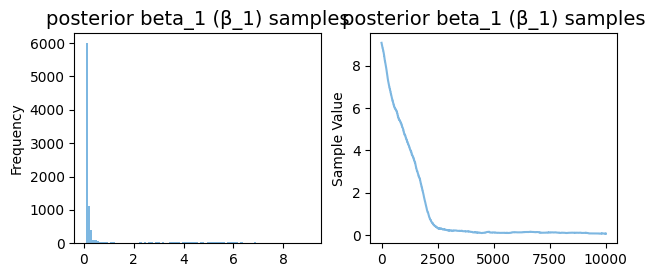

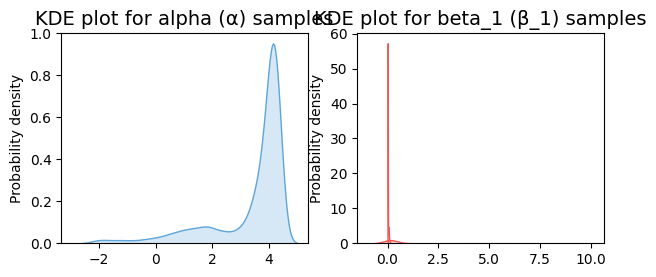

In [113]:
# plotting the Posterior Samples
import seaborn as sns

#alpha (α)
#beta (β)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(alphas, bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior alpha (α) samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), alphas, color=TFColor[6], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior alpha (α) samples', fontsize=14)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(beta_0, bins=100, color=TFColor[3], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior beta_0 (β_0) samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), beta_0, color=TFColor[3], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior beta_0 (β_0) samples', fontsize=14)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(beta_1, bins=100, color=TFColor[3], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior beta_1 (β_1) samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), beta_1, color=TFColor[3], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior beta_1 (β_1) samples', fontsize=14)

#KDE Plots
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
ax2 = sns.kdeplot(alphas, fill=True, color=TFColor[3], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for alpha (α) samples', fontsize=14)

plt.subplot(2, 2, 2)
ax1 = sns.kdeplot(beta_0, fill=True, color=TFColor[0], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for beta_0 (β_0) samples', fontsize=14)

plt.subplot(2, 2, 2)
ax1 = sns.kdeplot(beta_1, fill=True, color=TFColor[0], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for beta_1 (β_1) samples', fontsize=14)

Text(0.5, 0, '$\\lambda$')

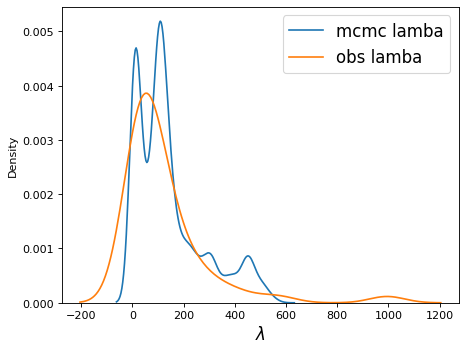

In [387]:
lambda_ = np.exp(alphas + betas)

plt.figure(dpi=80)
sns.kdeplot(lambda_, label='mcmc lamba')
sns.kdeplot(y_obs, label='obs lamba')
plt.legend(fontsize=15)
plt.xlabel("$\lambda$",size=15)

In [377]:
y_obs

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([ 53.,  42., 228., 162.,  61.,  36.,  18.,  24., 242.,  10.,  18.,
       340., 103.,  25.,  30.,  29.,  54., 378., 200., 126.,   3.,  24.,
       216.,  82.,   1., 231.,  51., 186.,  52.,  31., 100.,  99.,  51.,
       140.,   8., 111.,  87.,   7.,  20., 411.,  21.,  80.,  63., 118.,
         4., 122.,  10.,  95.,  43., 201.,  72.,  52.,  56., 162., 111.,
       287.,  59., 991., 139.,   7., 553.,  90.,  45.,  20.,  84.,  11.,
        99.,  13.,  21., 132.,   7.,   8., 467., 143.,  49.,  33., 999.,
        25., 133., 587.,  16.,  51., 357., 164.,  92.,  15.,  27.,  25.,
       105., 278., 144.,  19.,  15., 112., 283.,  18.,  95., 250.,  48.,
        35.])>

In [318]:
alphas = alphas.numpy().flatten()
betas = betas.numpy().flatten()

In [332]:
predict_func = lambda data: alphas + betas * data
x_train_data = X_train[:,0]

y_preds = np.zeros((len(x_train_data)))
for i, signal in enumerate(x_train_data):
    y_preds[i] = predict_func(signal).mean()

In [320]:
random_guess = tf.convert_to_tensor(np.random.uniform(0, 10, size=(len(y_preds), 1)).astype(np.float32))

In [337]:
train_event_set = tf.expand_dims(e_train.astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train))
y_pred = tf.convert_to_tensor(y_preds.reshape(len(y_preds), 1).astype(np.float32))

In [339]:
mcmc_train_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=y_pred)
random_guess_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=random_guess)
print(f"MCMC loss {mcmc_train_loss}, random: {random_guess_loss}")

MCMC loss 3.4211440086364746, random: 5.77722692489624
